# EK381 Exploratory Data Analysis <br> Lab 10: Confidence Intervals and Significance Testing

### This lab was completed by Rawisara Chairat.

## Please do not clear outputs for this lab, as some of the problems ask for generated figures.

In this lab, we will apply **confidence intervals** and **significance testing** to some real datasets. Our goals include:
- Understanding visualizations, especially for **confidence intervals**.
- Noticing that confidence intervals and p-values are not equivalent.
- Using the p-value to reject the null hypothesis.
- Modifying p-values to handle multiple null hypotheses.
- Understanding the flaws of p-values, especially for very large datasets.

Recall, from Video 9.1, given **independent and identically distributed** (i.i.d.) random variables $X_1,\ldots,X_n$ with mean $\mu$, we define the **sample mean** as
$$\hat{\mu} = M_n = \frac{1}{n} \sum_{i=1}^n X_i \ .$$ We say that $M_n \pm \epsilon = [M_n - \epsilon, M_n + \epsilon]$ is a confidence interval for the mean with confidence level $1-\alpha$ if $\mathbb{P}[ | M_n - \mu | > \epsilon] = \alpha$. By the Central Limit Theorem, we can approximate the distribution of $M_n$ as Gaussian, and this allows us to solve for $\epsilon$ in terms of $\alpha$ and the variance (whether it is known in advance or estimated from the data $X_1,\ldots,X_n$.

In [1]:
#numpy is a package for working with arrays, linear algebra, etc. and stands for "numerical Python".
import numpy as np
#pandas is a package for working with data frames.
import pandas as pd
#matplotlib is a plotting library that mimics Matlab conventions.
import matplotlib.pyplot as plt
#seaborn is a data visualization package.
import seaborn as sns
#scipy.stats is a statistics library.
import scipy.stats as st
#sklearn is a machine learning library.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Let's start by loading a pre-processed version of the EK381 entrance survey, that we last used in Lab 2. Specifically, the original data set was processed as follows:
- We only retained numerical data and the majors.
- Column names were shortened to make referencing them easier.
- In the survey, one answer to "Age at First Smartphone" was "18+". This was converted to "18" so that we can average it into the data.
- In the survey, a couple of students wrote the names of the countries they've visited, rather than just the number of countries as an integer. These answers were dropped. (This can be done via `pd.to_numeric(df,errors='coerce')`.) Another possibility would have been to manually change these entries.
- Instead of reporting the movie ratings as lists of movies underneath columns "loved", "liked", "OK", "disliked", and "hated", we give each movie its own column with possible values 5 (for "loved"), 4 (for "liked"), 3 (for "OK"), 2 (for "disliked"), 1 (for "hated"), and NaN (for "didn't see it"). This will make averaging the movie data much easier. (Recall that NaN means "Not a Number", and is excluded by basic pandas commands like `mean` and `var`.)

Overall, pre-processing is an extremely important (and time-consuming) step in exploratory data analysis.

In [2]:
survey_df = pd.read_csv("datasets/entrancesurvey_processed.csv") #Put the path to entrancesurvey.csv inside the quotes.
survey_df 

,major,smartphone age,number countries,Avengers: Endgame,Back to the Future,Barbie,Booksmart,Deadpool and Wolverine,Die Hard,Dune,...,Knives Out,Lady Bird,Mad Max: Fury Road,My Neighbor Totoro,Oppenheimer,Poor Things,Spider-Man: Into the Spiderverse,Star Wars: A New Hope,The Matrix,To All The Boys I've Loved
0,EE,18,25.0,5.0,NaN,4.0,2.0,3.0,4.0,3.0,...,NaN,NaN,NaN,3.0,1.0,NaN,NaN,2.0,2.0,2.0
1,EE,10,4.0,1.0,2.0,5.0,NaN,NaN,1.0,5.0,...,2.0,2.0,2.0,5.0,1.0,1.0,5.0,1.0,1.0,2.0
2,ME,13,7.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,5.0,5.0,3.0,NaN
3,BME,16,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ME,12,14.0,4.0,5.0,3.0,5.0,1.0,5.0,2.0,...,5.0,NaN,NaN,5.0,3.0,NaN,5.0,5.0,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,ME,13,2.0,4.0,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
211,EE,14,15.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,4.0,5.0,5.0,NaN
212,BME,13,2.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213,BME,11,15.0,5.0,NaN,5.0,NaN,NaN,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's start by computing the mean age at the time of first smartphone ("smartphone age") for each major. The following code will give us the numerical values.

In [3]:
survey_df.groupby('major')['smartphone age'].mean()

major
BME    12.145833
CE     12.065217
EE     13.368421
ME     12.462963
Name: smartphone age, dtype: float64

Alternatively, we can go straight to the visualization using `sns.barplot`, setting the x-values to be `major` and the y-values to be `smartphone age`. We've also set hue to `major` as well so that each bar is a different color. From the plot, you should see that, on average, EE majors got their first smartphone about a year later than other majors.

<Axes: xlabel='major', ylabel='smartphone age'>

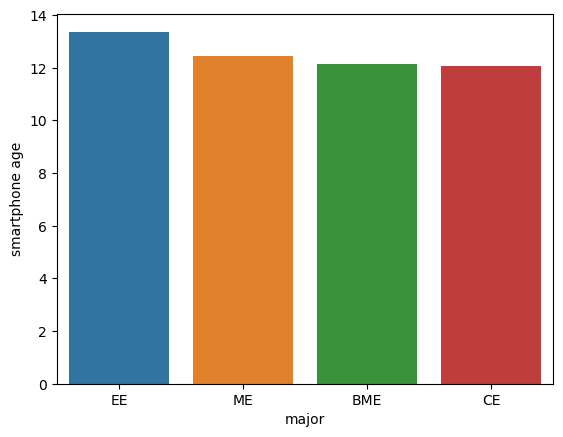

In [4]:
sns.barplot(data=survey_df,x='major',y='smartphone age',hue='major',errorbar=None)

Now, let's add confidence intervals to our barplot. This is also built into `sns.barplot` as `errorbar`. Let's start by using the Gaussian confidence interval for known variance **or** more than $30$ samples (even though this is not technically true since we do not know the variance and we only have 19 responses from EE majors). We know that in this setting we should set $\epsilon = \frac{\sigma}{\sqrt{n}} Q^{-1}(\alpha/2)$. Recall that $Q^{-1}(0.05) = 1.64$, $Q^{-1}(0.025) = 1.96$, and $Q^{-1}(0.005) = 2.57$ so 
- for confidence level $0.9$, we should set $\epsilon = \frac{\sigma}{\sqrt{n}} 1.64$,
- for confidence level $0.95$, we should set $\epsilon = \frac{\sigma}{\sqrt{n}} 1.96$,
- for confidence level $0.99$, we should set $\epsilon = \frac{\sigma}{\sqrt{n}} 2.57$.

It turns out that all we need to do is set $\text{errorbar} = (\text{`se'},Q^{-1}(\alpha/2))$, below is an example that shows confidence level $0.95$.

<Axes: xlabel='major', ylabel='smartphone age'>

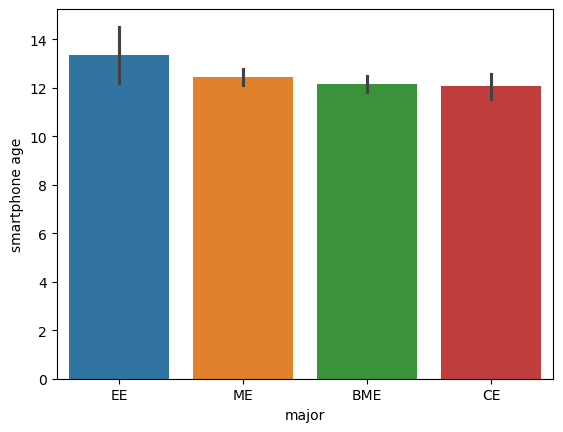

In [5]:
sns.barplot(data=survey_df,x='major',y='smartphone age',hue='major',errorbar=('se',1.96))

Another way to compute confidence intervals is directly via the data using a method called **bootstrapping**. This is beyond our scope, but at a high level, involves resampling the dataset with replacement many times. See [this video](https://www.youtube.com/watch?v=TqOeMYtOc1w) or [this wikipedia page](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) for more details. This is the built-in confidence interval for `sns.barplot` with default confidence level $0.95$. You should see no visual difference between the plot below and the plot above, which used Gaussian confidence intervals.

<Axes: xlabel='major', ylabel='smartphone age'>

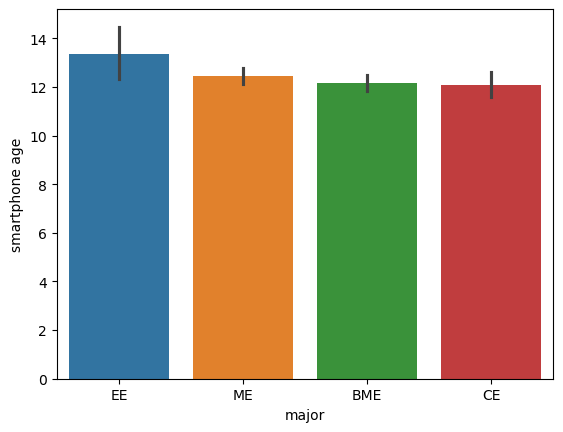

In [6]:
sns.barplot(data=survey_df,x='major',y='smartphone age',hue='major')

If you want to change the confidence level, you can use the `errorbar =('ci',95)` parameter, and change 95 to your desired value.

<Axes: xlabel='major', ylabel='smartphone age'>

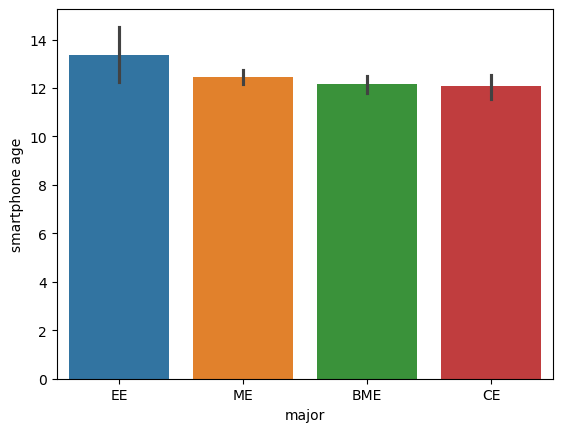

In [19]:
sns.barplot(data=survey_df,x='major',y='smartphone age',hue='major',errorbar=('ci',95))

---
####  L10.1 Using the code above, change the confidence level. How does the confidence interval length change as you decrease the confidence level? Explain why this makes sense.

#### Answer: The confidence intervals length becomes shorter as the confidence level decreases because a lower confidence level allows for a smaller range around the estimate.
---

Now, let's consider the following question: Did EE majors, on average, get their first smartphone significantly later than CE majors? From the plot, we can see that the 95% confidence intervals overlap. Does this mean we should conclude that the EE and CE means are the same? It turns out that confidence intervals are not the right framework to anwer this question. Instead, we should use the **significance testing** framework. Recall that, in Video 9.3, we considered the following options:
- *One-Sample Z-Test:* Comparing the mean of a dataset with known variance $\sigma^2$ to a baseline mean $\mu$.
- *One-Sample T-Test:* Comparing the mean of a dataset with unknown variance to a baseline mean $\mu$.
- *Two-Sample Z-Test:* Comparing the means of two datasets with known variances $\sigma_1^2$ and $\sigma_2^2$.
- *Two-Sample T-Test:* Comparing the means of two datasets with unknown but equal variance.

Each of these tests outputs a $\textrm{p-value}$ that we need to compare to our pre-selected significance level $\alpha$. If $\textrm{p-value} < \alpha$, we **reject the null hypothesis,** which is the formal, statistical language for deciding that the means are significantly different. Otherwise, if $\textrm{p-value} \geq \alpha$, we **fail to reject the null hypothesis,** which is the formal, statistical language for deciding that the means are not significantly different, i.e., they are statistically indistinguishable for the given data.

It turns out that the two-sample T-test is the best match for our scenario, since we are comparing two datasets, we do not know the variances, and it is reasonable to assume that the variances are the same. The code below extracts the smartphone age data for each major and computes the T-statistic and the corresponding p-value. Recall from Video 9.3 that the equations are 
$$\sigma^2_{\text{pooled}} = \frac{(n_1 - 1) \hat{\sigma}_1^2 + (n_2 - 1) \hat{\sigma}_2^2}{n_1 + n_2 - 2} \qquad \qquad T = \frac{\hat{\mu}_1  - \hat{\mu}_2}{\sigma_{\text{pooled}} \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}} \qquad  \qquad \textrm{p-value} = 2 F_{T_{n_1 + n_2 - 2}}(-|T|)$$
where $n_1, \hat{\mu}_1, \hat{\sigma}_1^2$ are the number of samples, sample mean, and sample variances for the first dataset, and $n_2, \hat{\mu}_2, \hat{\sigma}_2^2$ are the number of samples, sample mean, and sample variances for the second dataset. We will also decide to use a significance level of $\alpha = 0.05$.

In [20]:
# Set significance level
significance_level = 0.05

# Extract the two groups to compare from the full dataset.
group1 = survey_df[survey_df['major'] == 'EE']['smartphone age']
group2 = survey_df[survey_df['major'] == 'CE']['smartphone age']

# Calculate the sample sizes, means, and variances for each group.
n1 = group1.size
n2 = group2.size
mean1 = group1.mean()
mean2 = group2.mean()
var1 = group1.var()
var2 = group2.var()

# Perform a two-sample T-test
varpool = ((n1-1)*var1 + (n2-1)*var2)/(n1 + n2 - 2) #pool the variance estimates (since we presume equal variance)
t_stat = (mean1-mean2)/(np.sqrt(varpool * (1/n1 + 1/n2))) #calculate the T-statistic
p_value = 2*st.t.cdf(-np.abs(t_stat),n1+n2-2) #calculate the p-value using a T-distribution with n1+n2-2 degrees-of-freedom
print(f"T-statistic: {t_stat}, P-value: {p_value}") #output the T-statistic and p-value
if p_value < significance_level:
    print('Reject the null hypothesis at a significance level of ' + str(significance_level) + '.')
else:
    print('Fall to reject the null hypothesis at a significance level of ' + str(significance_level) + '.')

T-statistic: 2.346788235142763, P-value: 0.022093406460019352
Reject the null hypothesis at a significance level of 0.05.


Since the p-value is less than 0.05, we should reject the null hypothesis, and conclude that the difference between the EE and CE means is statistically significant. You can also use the built-in function `ttest_ind` from `scipy.stats` to do this automatically

In [21]:
group1 = survey_df[survey_df['major'] == 'EE']['smartphone age']
group2 = survey_df[survey_df['major'] == 'CE']['smartphone age']
# Perform a two-sample T-test
t_stat, p_value = st.ttest_ind(group1, group2, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")
if p_value < significance_level:
    print('Reject the null hypothesis at a significance level of ' + str(significance_level) + '.')
else:
    print('Fall to reject the null hypothesis at a significance level of ' + str(significance_level) + '.')

T-statistic: 2.346788235142763, P-value: 0.022093406460019352
Reject the null hypothesis at a significance level of 0.05.


<Axes: xlabel='major', ylabel='number countries'>

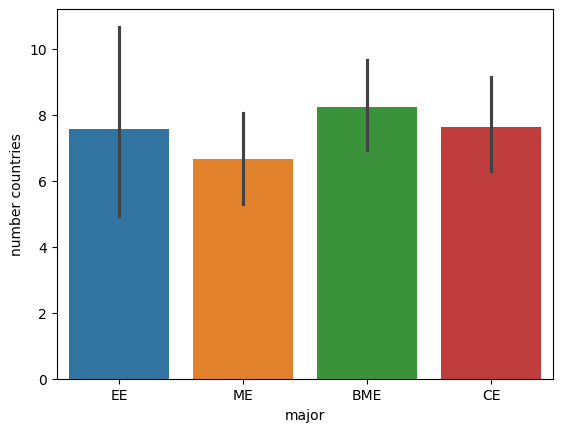

In [23]:
survey_df.groupby('major')['number countries'].mean()
sns.barplot(data=survey_df,x='major',y='number countries',hue='major',errorbar=('ci',95))

In [25]:
# Set significance level
significance_level = 0.05

# Extract the two groups to compare from the full dataset.
group1 = survey_df[survey_df['major'] == 'BME']['number countries']
group2 = survey_df[survey_df['major'] == 'ME']['number countries']

# Calculate the sample sizes, means, and variances for each group.
n1 = group1.size
n2 = group2.size
mean1 = group1.mean()
mean2 = group2.mean()
var1 = group1.var()
var2 = group2.var()

# Perform a two-sample T-test
varpool = ((n1-1)*var1 + (n2-1)*var2)/(n1 + n2 - 2) #pool the variance estimates (since we presume equal variance)
t_stat = (mean1-mean2)/(np.sqrt(varpool * (1/n1 + 1/n2))) #calculate the T-statistic
p_value = 2*st.t.cdf(-np.abs(t_stat),n1+n2-2) #calculate the p-value using a T-distribution with n1+n2-2 degrees-of-freedom
print(f"T-statistic: {t_stat}, P-value: {p_value}") #output the T-statistic and p-value
if p_value < significance_level:
    print('Reject the null hypothesis at a significance level of ' + str(significance_level) + '.')
else:
    print('Fall to reject the null hypothesis at a significance level of ' + str(significance_level) + '.')

T-statistic: 1.4256132200706078, P-value: 0.15608570961372875
Fall to reject the null hypothesis at a significance level of 0.05.


In [27]:
group1 = survey_df[survey_df['major'] == 'BME']['number countries'].dropna()
group2 = survey_df[survey_df['major'] == 'ME']['number countries'].dropna()
# Perform a two-sample T-test
t_stat, p_value = st.ttest_ind(group1, group2, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")
if p_value < significance_level:
    print('Reject the null hypothesis at a significance level of ' + str(significance_level) + '.')
else:
    print('Fall to reject the null hypothesis at a significance level of ' + str(significance_level) + '.')

T-statistic: 1.5060228398062987, P-value: 0.13450239762304883
Fall to reject the null hypothesis at a significance level of 0.05.


---
####  L10.2 Now, let's examine the data for the number of countries that each survey respondent has visited. 
#### (a) Create a bar plot for the average number of countries visited by each major along with a 95% confidence interval. Which major, on average, has visited the most countries? Which major, on average, has visited the least? From the plot, do you think this is a significant finding (before formally checking the p-value)?

#### Major with Highest Mean: BME
#### Major with Lowest Mean: ME
#### Guess as to whether this is significant: Not significant

#### (b) Now, go ahead and compare the means for the two majors you selected in part (a) using significance testing with a significance level of 0.05. If you use the built-in function `st.ttest_ind` you will get an error. This is because this survey question was not a required field (whereas the smartphone age was). To ignore the correspond "NaN" values, you need to add the command `.dropna()` to the end of your code for creating each group. Report the resulting p-value and your decision.

#### p-value = 0.1561
#### Decision: Fail to reject the null hypothesis at a significance level of 0.05.

#### (c) It turns out that the built-in function `st.ttest_ind` allows us to use a T-test with unequal variances (i.e., [Welch's T-test](https://en.wikipedia.org/wiki/Welch%27s_t-test)), which we did not cover in class. Try this out by setting `equal_var = False`. Report the resulting p-value and your conclusion.

#### p-value = 0.1345
#### Decision = Fail to reject the null hypothesis at a significance level of 0.05.
---

<Axes: xlabel='major', ylabel='Dune'>

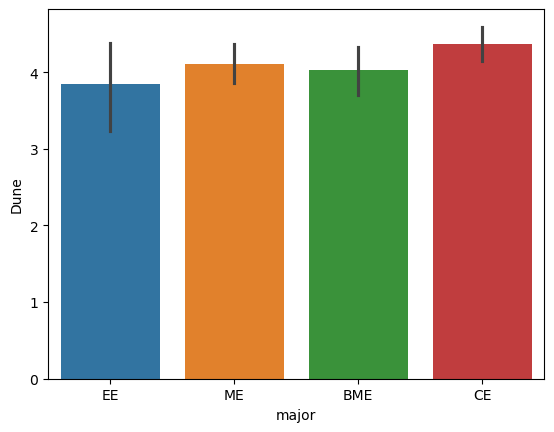

In [36]:
survey_df.groupby('major')['Dune'].mean()
sns.barplot(data=survey_df,x='major',y='Dune',hue='major',errorbar=('ci',95))

In [54]:
group1 = survey_df[survey_df['major'] == 'CE']['Dune']
group2 = survey_df[survey_df['major'] == 'EE']['Dune']
var1 = group1.var()
var2 = group2.var()
print(var1, var2)

0.3190883190883192 1.3076923076923077


In [43]:
# Set significance level
significance_level = 0.05

# Extract the two groups to compare from the full dataset.
group1 = survey_df[survey_df['major'] == 'CE']['Dune']
group2 = survey_df[survey_df['major'] == 'EE']['Dune']

# Calculate the sample sizes, means, and variances for each group.
n1 = group1.size
n2 = group2.size
mean1 = group1.mean()
mean2 = group2.mean()
var1 = group1.var()
var2 = group2.var()

# Perform a two-sample T-test
varpool = ((n1-1)*var1 + (n2-1)*var2)/(n1 + n2 - 2) #pool the variance estimates (since we presume equal variance)
t_stat = (mean1-mean2)/(np.sqrt(varpool * (1/n1 + 1/n2))) #calculate the T-statistic
p_value = 2*st.t.cdf(-np.abs(t_stat),n1+n2-2) #calculate the p-value using a T-distribution with n1+n2-2 degrees-of-freedom
print(f"T-statistic: {t_stat}, P-value: {p_value}") #output the T-statistic and p-value
if p_value < significance_level:
    print('Reject the null hypothesis at a significance level of ' + str(significance_level) + '.')
else:
    print('Fall to reject the null hypothesis at a significance level of ' + str(significance_level) + '.')

T-statistic: 2.4784211454250573, P-value: 0.015887431332417892
Reject the null hypothesis at a significance level of 0.05.


In [38]:
group1 = survey_df[survey_df['major'] == 'CE']['Dune'].dropna()
group2 = survey_df[survey_df['major'] == 'EE']['Dune'].dropna()
# Perform a two-sample T-test
t_stat, p_value = st.ttest_ind(group1, group2, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")
if p_value < significance_level:
    print('Reject the null hypothesis at a significance level of ' + str(significance_level) + '.')
else:
    print('Fall to reject the null hypothesis at a significance level of ' + str(significance_level) + '.')

T-statistic: 1.5635386287332487, P-value: 0.13892566957970495
Fall to reject the null hypothesis at a significance level of 0.05.


---
####  L10.3 Pick one of the movies from the survey and use the data in that column for the following questions.
#### (a) Which major gave your movie the highest average rating? Which major gave the lowest average rating?

#### Major with Highest Mean: CE
#### Major with Lowest Mean: EE

#### (b) Now, construct a significance test to determine if the difference between the highest and lowest mean you found in part (a) are statistically signifcant. Be sure to decide your significance in advance, before looking at the p-value.

#### Significance Level = 0.05
#### Type of Significance Test (including whether variances are equal): Two-sample T-test with unequal variances
#### p-value = 0.1389
#### Decision: Fail to reject the null hypothesis at a significance level of 0.05.
---

Let's try to examine all of the movie ratings simultaneously (without paying attention to the major). We could compute the means and confidence intervals ourselves, and then make a plot, or we could use `sns.barplot` to achieve this directly. One issue is that `sns.barplot` will not accept the data in its current format so we need to collapse or `melt` the data into a two-format, as we have done below.

In [44]:
movies_df = survey_df.iloc[:,3:] #Extract only the movie columns
movies_melt_df = movies_df.melt(var_name='Movie', value_name='Rating') #Put the movie data into a two-column format
movies_melt_df['Rating'] = pd.to_numeric(movies_melt_df['Rating'], errors='coerce') #Ensure data is numeric
movies_melt_df

,Movie,Rating
0,Avengers: Endgame,5.0
1,Avengers: Endgame,1.0
2,Avengers: Endgame,NaN
3,Avengers: Endgame,NaN
4,Avengers: Endgame,4.0
...,...,...
4940,To All The Boys I've Loved,NaN
4941,To All The Boys I've Loved,NaN
4942,To All The Boys I've Loved,NaN
4943,To All The Boys I've Loved,NaN


---
#### 10.4 Now, create a barplot for the mean movie ratings with a 95% confidence interval. Note that the movie titles will collide if you simply take `x="Movie"` and `y="Rating"`. Here are two workarounds, choose your favorite:
1. Rotate the titles on the x-axis by 45 degress via `plt.xticks(rotation=45,ha='right')`
2. Plot the movie titles on the y-axis and the ratings on the x-axis instead.
--- 

<Axes: xlabel='Rating', ylabel='Movie'>

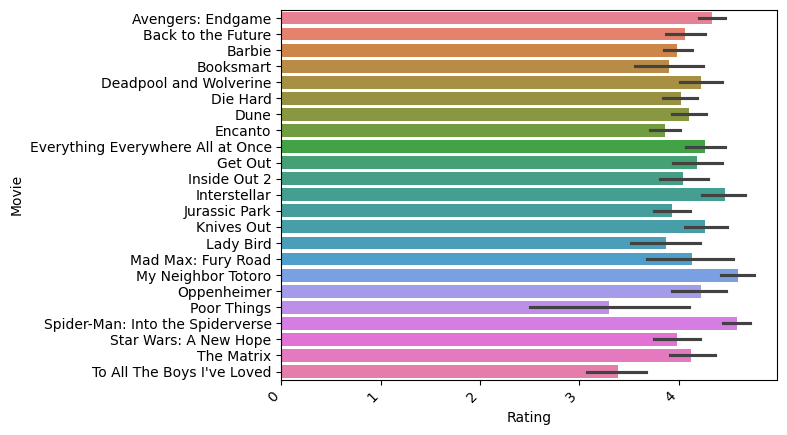

In [47]:
plt.xticks(rotation=45,ha='right')
sns.barplot(data=movies_melt_df,x='Rating',y='Movie',hue='Movie',errorbar=('ci',95))

---
#### 10.5 From the plot, it is hard to visually discern the ranking of the movies by average rating. How can we sort by average rating? First we need to create a sorting order via `sorting_order = movies_melt_df.groupby('Movie')['Rating'].mean().sort_values().index` and then we can pass this to `sns.barplot` via the parameter `order = sorting_order`. Go ahead and generate another bar plot using this sorting, and then report the movie with the highest mean rating and the movie with the lowest mean rating:

#### Highest-rated movie: My Neighbor Totoro
#### Lowest-rated movie: Poor Things
--- 

<Axes: xlabel='Rating', ylabel='Movie'>

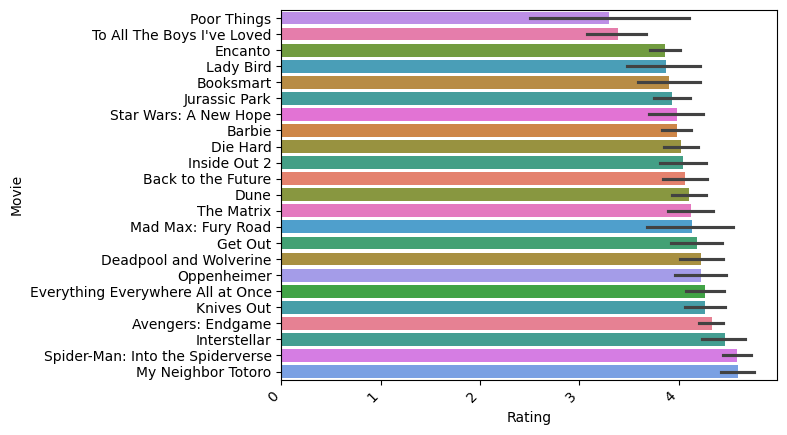

In [48]:
plt.xticks(rotation=45,ha='right')
sorting_order = movies_melt_df.groupby('Movie')['Rating'].mean().sort_values().index
sns.barplot(data=movies_melt_df,x='Rating',y='Movie',hue='Movie',errorbar=('ci',95),order = sorting_order)

The code below calculates the p-value for a significance test between the mean of `target_movie` and all other movies in the dataset. It returns a dataframe containing all of the p-values, followed by a subset of this dataframe containing all movies whose p-value falls below the pre-set significance level. We would like to be able to claim that the difference between the mean rating for each of these movies and the mean rating of the target rating is statistically significant. (This could be due to either a higher rating or a lower rating.)

In [49]:
# Set the target movie
target_movie = "The Matrix"  # Replace with the name of the target movie
# Choose the significance level
significance_level = 0.05 
# Filter ratings for the target movie
target_ratings = movies_melt_df[movies_melt_df['Movie'] == target_movie]['Rating'].dropna()
# Initialize a list to store p-values
p_values_list = []
# Get array of movies
movies_array = movies_melt_df['Movie'].unique()

# Calculate p-values for each movie
for movie in movies_array:
    if movie != target_movie:  # Skip comparison with the target movie itself
        other_ratings = movies_melt_df[movies_melt_df['Movie'] == movie]['Rating'].dropna()
        # Perform t-test
        t_stat, p_value = st.ttest_ind(target_ratings, other_ratings, equal_var=False)  # Welch's t-test
        # Store the result
        p_values_list.append({'Movie': movie, 'Mean Rating': other_ratings.mean(), 'P-Value': p_value})

p_values_df = pd.DataFrame(p_values_list)
print('P-values compared to ' + str(target_movie) + ', which has mean rating ' + str(target_ratings.mean()) + '.')
display(p_values_df)
reject_null_df = p_values_df[p_values_df["P-Value"] < significance_level]
print('For the following movies, we reject the null hypothesis that the mean rating is equal to that of ' + str(target_movie) + ' at a significance level of ' + str(significance_level) + '.')
reject_null_df

P-values compared to The Matrix, which has mean rating 4.127272727272727.


,Movie,Mean Rating,P-Value
0,Avengers: Endgame,4.335329,0.127997
1,Back to the Future,4.063492,0.692564
2,Barbie,3.987342,0.322658
3,Booksmart,3.906250,0.291434
4,Deadpool and Wolverine,4.223684,0.563597
5,Die Hard,4.025974,0.493059
6,Dune,4.109091,0.901335
7,Encanto,3.866667,0.068668
8,Everything Everywhere All at Once,4.263158,0.376256
9,Get Out,4.189189,0.723619


For the following movies, we reject the null hypothesis that the mean rating is equal to that of The Matrix at a significance level of 0.05.


,Movie,Mean Rating,P-Value
11,Interstellar,4.468750,0.038358
16,My Neighbor Totoro,4.600000,0.001803
19,Spider-Man: Into the Spiderverse,4.589744,0.001160
21,To All The Boys I've Loved,3.387755,0.000219


One issue with the procedure above is that we are running multiple significance tests simultaneously. Therefore, if we simply compare movies with the desired significance level, we cannot claim that our final list of movies has the desired significance level. There are many ways to get around this issue, most of which are beyond the scope of our class. (Here is an [xkcd comic strip](https://xkcd.com/882/) that refers to this issue.) However, there is a simple (but overly cautious) fix that we can learn now. Instead of using the desired significance level $\alpha$, we should compare each movie to the **Bonferroni-corrected** significance level $\alpha_{\text{corrected}} = \displaystyle \frac{\alpha}{\# \text{significance tests}}$. (In our setting, the number of significance tests is equal to the number of movies, minus 1.) By using this more conservative significance level for each individual significance test, we can certify that our overall set of decisions has the desired significance level $\alpha$. 

---
#### 10.6 Modify the code above to make individual comparisons using the Bonferroni-corrected significance level. Select a movie as the target movie, set the overall significance level to 0.05, and determine the list of movies that have significantly different mean ratings from your selection.

#### Bonferroni-corrected significance level = 0.0023
#### Choice of target movie = The Matrix
#### List of movies that have significantly different mean ratings at significance level 0.05 = My Neighbor Totoro, Spider-Man: Into the Spiderverse, To All The Boys I've Loved
--- 

In [50]:
# Set the target movie
target_movie = "The Matrix"  # Replace with the name of the target movie
# Choose the significance level
significance_level = 0.05 / 22
# Filter ratings for the target movie
target_ratings = movies_melt_df[movies_melt_df['Movie'] == target_movie]['Rating'].dropna()
# Initialize a list to store p-values
p_values_list = []
# Get array of movies
movies_array = movies_melt_df['Movie'].unique()

# Calculate p-values for each movie
for movie in movies_array:
    if movie != target_movie:  # Skip comparison with the target movie itself
        other_ratings = movies_melt_df[movies_melt_df['Movie'] == movie]['Rating'].dropna()
        # Perform t-test
        t_stat, p_value = st.ttest_ind(target_ratings, other_ratings, equal_var=False)  # Welch's t-test
        # Store the result
        p_values_list.append({'Movie': movie, 'Mean Rating': other_ratings.mean(), 'P-Value': p_value})

p_values_df = pd.DataFrame(p_values_list)
print('P-values compared to ' + str(target_movie) + ', which has mean rating ' + str(target_ratings.mean()) + '.')
display(p_values_df)
reject_null_df = p_values_df[p_values_df["P-Value"] < significance_level]
print('For the following movies, we reject the null hypothesis that the mean rating is equal to that of ' + str(target_movie) + ' at a significance level of ' + str(significance_level) + '.')
reject_null_df

P-values compared to The Matrix, which has mean rating 4.127272727272727.


,Movie,Mean Rating,P-Value
0,Avengers: Endgame,4.335329,0.127997
1,Back to the Future,4.063492,0.692564
2,Barbie,3.987342,0.322658
3,Booksmart,3.906250,0.291434
4,Deadpool and Wolverine,4.223684,0.563597
5,Die Hard,4.025974,0.493059
6,Dune,4.109091,0.901335
7,Encanto,3.866667,0.068668
8,Everything Everywhere All at Once,4.263158,0.376256
9,Get Out,4.189189,0.723619


For the following movies, we reject the null hypothesis that the mean rating is equal to that of The Matrix at a significance level of 0.002272727272727273.


,Movie,Mean Rating,P-Value
16,My Neighbor Totoro,4.600000,0.001803
19,Spider-Man: Into the Spiderverse,4.589744,0.001160
21,To All The Boys I've Loved,3.387755,0.000219
